**Synchronize to Google Drive**

This feature makes the google colab to connect to the google drive with mounting GDrive and defining the path.

In [2]:
# Synchronize to google drive, define the root path
import os

google_colab  = True
if google_colab == True:
  #This statement used to pointing the google drive storage 
  from google.colab import drive
  drive.mount('/content/gdrive')
  root_path = 'gdrive/My Drive/Colab Notebooks/'

  #This statement is purposed to import library from the Drive
  os.chdir('gdrive/My Drive/Colab Notebooks/')
  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
np.random.seed(0)
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, GRU, Activation, Flatten
from tensorflow.keras.models import Model
#from keras.models import Model
#from keras.layers import Dense, Input, Dropout, LSTM, Activation, Flatten, GRU, Concatenate
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(1)

**Loading the dataset**

Currently, The experiment is using the dataset from CNN/Daily News. It designed to support Extractive Summarization method in which extract all of documents through pre-processing and store all of sentences to cnn-sentences.pkl and each of sentence has labeled based on whether its sentence is similar or exist on the summaries/highlight (labeled 1) or no (labeled 0)

In [4]:
import nltk
import collections
import pickle #data preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
nltk.download('punkt')
NUM_WORDS=25000
counter = collections.Counter()
print('Dataset loading ...')
#import postprocessing as pr #helper
#Step 1 - Load data
#Step 1 - Load data
with open('datasets/dataset-duc2001.pkl', 'rb') as fp:
    data_2001 = pickle.load(fp)

with open('datasets/dataset-duc2002.pkl', 'rb') as fp:
    data_2002 = pickle.load(fp)

clusterSentences_2001, clusterDocuments_2001, clusterSummaries_2001, listY_2001 = data_2001
clusterSentences_2002, clusterDocuments_2002, clusterSummaries_2002, listY_2002 = data_2002

clusterSentences = clusterSentences_2001 + clusterSentences_2002
clusterDocuments = clusterDocuments_2001 + clusterDocuments_2002
listY = listY_2001 + listY_2002

# Extract to become one bucket of sentences
sentences = []
for clusterSentence in clusterSentences:
  for sentence in clusterSentence:
    sentences.append(sentence)

tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
index_word = tokenizer.index_word
index_docs = tokenizer.index_docs
vocabularySize = len(word_index) + 1

#nWord = [len(sentence.split()) for sentence in sentences]
#nWord = sorted(nWord,  reverse=True)
#words = [sentence.split() for sentence in sentences]
#nWord = [len(sentence.split()) for sentence in sentences]
#maxlen = max(nWord)
sentenceLength = 200

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Dataset loading ...


In [6]:
print('total of words :', len(word_index))
print('total of sentences', len(sentences))
total_documents = 0
for docs in clusterDocuments:
  total_documents += len(docs)
print('total of documents', total_documents)
print('total of clusters', len(clusterSentences))

total of words : 30372
total of sentences 28787
total of documents 866
total of clusters 89


**Load Pre-trained Word2Vec**

We use gensim to load Word2Vec which is provided Google. It can be downloaded from https://code.google.com/archive/p/word2vec/

In [7]:
from gensim.models import KeyedVectors
WORD2VEC_MODEL = "word-embeddings/word2vec/GoogleNews-vectors-negative300.bin.gz"
word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Define Y target**

Y target defined as categorical data but ideally it should be binary

In [8]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y
    
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
xs, ys = [], []
for sentence in sentences:
  words = [x.lower() for x in sentence.split()]
  wids = [word_index[word] for word in words]
  xs.append(wids)

ys = []
for clusterY in listY:
  for sentenceY in clusterY:
    ys.append(sentenceY)

X = pad_sequences(xs, maxlen=sentenceLength)
Y = np.array(ys)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.02, random_state=1)
Y_train_oh = convert_to_one_hot(Ytrain, C = 2)
Y_test_oh = convert_to_one_hot(Ytest, C = 2)


### if want to reshape the target #############################################
#Y_train_oh = Y_train_oh.reshape(Y_train_oh.shape[0], Y_train_oh.shape[1], 1)
#Y_test_oh = Y_test_oh.reshape(Y_test_oh.shape[0], Y_test_oh.shape[1], 1)
#print(Y_train_oh[0])
#print(Y_test_oh[0])

Using TensorFlow backend.


**Embedding Layer**

This function is used to embed pre-trained word2vec as defined before, the function is to produce the matrix from all of the sentences which were mapped to word2vec

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained Word2Vec 300-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their Word2Vec vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (30,372 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        try:
          emb_matrix[index, :] = word_to_vec_map[word]
        except:
          emb_matrix[index, :] = 0

    # Define Keras embedding layer with the correct output/input sizes, make it non-trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
embedding_layer = pretrained_embedding_layer(word2vec, word_index)

**Attention Model**

This function is implementing attention model from bahdanau 


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    salienceScores = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = salienceScores * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, salienceScores

**Model 2 (GRU without Attention)**

This model used to produce sentence embedding from a cluster document with $ N $sentences (s$_1$, s$_2$, ... , s$_N$) in total. for each sentence s$_i$ of $ L $ words (w$_1$, w$_2$, ..., w$_L$), GRU$^sent$ recurrently updates hidden states at each time step t:

h$_t ^{sent} = GRU^{sent} h_{t-1} ^{sent} . w_t $ ......... (4)

where w$_t$ is the word embedding for w$_t$, h$_t ^{sent}$ is the hidden state of GRU$^{sent}$. h$_0$ is initialized as a zero vector, and the input sentence embedding x$_i$ is the last hidden state :

x$_i = h_L ^{sent}$ ....................................... (5)

All sentence embeddings from the given document cluster are grouped as the node feature matrix X :

$X = 
\quad
\begin{bmatrix}
- X_1 - \\
- X_2 - \\
. \\
. \\
. \\
- X_N - 
\end{bmatrix}$ 



**Model 3 (GRU with Attention)**

In [0]:
import tensorflow.keras.regularizers as kr
def model_3(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    emb_dim=300
    encoder_inputs = Input(input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(encoder_inputs)  
    
    # Sentence Embedding
    kernel_regularizer = kr.l1(0.01)
    GRUsents = GRU(300, return_sequences=True, return_state=True, dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=kernel_regularizer) 
    sentence_embedding, state_h =  GRUsents(embeddings)
    
    # Document Embedding
    GRUdocs = GRU(300, return_sequences=False, return_state=False)
    document_embedding = GRUdocs(sentence_embedding)
    
    # Cluster Embedding
    ##l = 1./10
    ##l = tf.constant(l)
    ##avgDocEmb = tf.reduce_sum(document_embedding, 0, keepdims=True)
    ##c = tf.math.multiply(l, avgDocEmb)
    ##cluster_emb = c
    
    # Attention Layer
    units=1
    attn_layer = BahdanauAttention(units)
    context_vector, salienceScores = attn_layer(document_embedding, sentence_embedding) 
    #gru= GRU(300, return_sequences=False, return_state=False, dropout=0.2, recurrent_dropout=0.2) 
    #X = gru(salienceScores)
    X = Flatten()(salienceScores)
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=encoder_inputs, outputs=X)
    ### END CODE HERE ###
    
    return model

**Build the model and summary**

In [14]:
model = model_3((X.shape[1],), word2vec, word_index)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          9111900   
_________________________________________________________________
gru (GRU)                    [(None, 200, 300), (None, 540900    
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               540900    
_________________________________________________________________
bahdanau_attention (Bahdanau ((None, 300), (None, 200, 604       
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402   

**Compile the Model and Train the Model**

In [0]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, clipnorm=1.0), metrics=['accuracy'])

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(Xtrain,Y_train_oh, epochs = 50, batch_size = 512, validation_data=(Xtest, Y_test_oh), callbacks=[es])
score = model.evaluate(Xtest, Y_test_oh, verbose=1)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

with open('rnn/models/model2-trainHistoryDict', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)
  print("Saved training history to disk")

Train on 28211 samples, validate on 576 samples
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
28211/28211 [==============================] - 573s 20ms/sample - loss: 42.8681 - acc: 0.8949 - val_loss: 6.4242 - val_acc: 0.9375
Epoch 2/50
28211/28211 [==============================] - 561s 20ms/sample - loss: 2.0639 - acc: 0.9438 - val_loss: 0.9283 - val_acc: 0.9375
Epoch 3/50
28211/28211 [==============================] - 561s 20ms/sample - loss: 0.8463 - acc: 0.9438 - val_loss: 0.8086 - val_acc: 0.9375
Epoch 4/50
28211/28211 [==============================] - 560s 20ms/sample - loss: 0.7783 - acc: 0.9438 - val_loss: 0.7597 - val_acc: 0.9375
Epoch 5/50
28211/28211 [==============================] - 559s 20ms/sample - loss: 0.7339 - acc: 0.9438 - val_loss: 0.7210 - val_acc: 0.9375
Epoch 6/50
28211/28211 [==============================] - 554s 20ms/sample - loss: 0.6993 - acc: 0.9438 - val_loss: 0.6910 - val_acc: 0.9375
Epoch 7/50


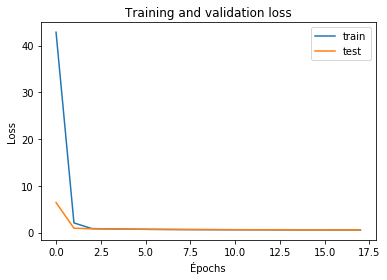

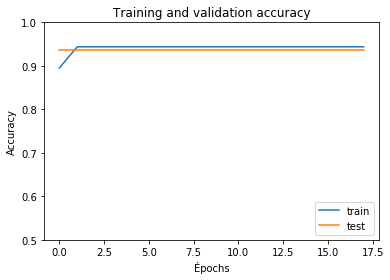

In [17]:
from matplotlib import pyplot
fig = pyplot.figure()
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.title('Training and validation loss')
pyplot.xlabel('Épochs')
pyplot.ylabel('Loss')
pyplot.legend() 
pyplot.show()
#fname='training-and-validation-loss-model2.jpg'
#fig.savefig(fname)

fig2 = pyplot.figure()
pyplot.plot(history.history['acc'], label='train') 
pyplot.plot(history.history['val_acc'], label='test') 
pyplot.title('Training and validation accuracy')
pyplot.xlabel('Épochs')
pyplot.ylabel('Accuracy')
pyplot.legend(loc='lower right')
pyplot.ylim((0.5, 1))
pyplot.show()
#fname='training-and-validation-accuracy-model2.jpg'
#fig2.savefig(fname)

**Model Prediction**

In [18]:
test_docs = clusterSentences[15]
xs_test=[]
#print(len(test_docs))
for sentence in test_docs:
  words = [x.lower() for x in nltk.word_tokenize(sentence)]
  wids = [word_index[word] for word in words]
  xs_test.append(wids)
X_Test = pad_sequences(xs_test, maxlen=sentenceLength)
Y_Test = np.array(listY[0])
pred = model.predict(X_Test)
sentence_test = []
salience_score_list = {}
score_list = []
for i in range(len(X_Test)):
    num = np.argmax(pred[i])
    pred_num = pred[i]
    sentence_list = []
    for idx in X_Test[i]:
      if idx != 0:
        sentence_list.append(index_word[idx])
    sentence_list = ' '.join(sentence_list)
    salience_score_list[sentence_list] = pred_num[1]
    sentence_test.append(sentence_list)

ordering = sorted(salience_score_list, key=lambda k: salience_score_list[k],  reverse=True)
summary_list = []
sentence_length = 0
for sent in ordering:
  length = len(sent.split())
  if (length > 5 and length < 55):
    if sentence_length <= 88:
      #print(len(sent.split()))
      summary_list.append(sent)
      sentence_length += length
summary = ' '.join(summary_list)
print('Predicted Summary:')
print(summary)
print()
print('Length of summary',len(summary.split()))
print()
print('The summary sentences salience score:')
for sent in summary_list:
  print(salience_score_list[sent])

Predicted Summary:
we feel there is no need to do so sentence as heard patten i must say that like the overwhelming majority of people in hong kong like a number of members of the pwc i think it is a great pity that we are as it were communicating through television rather than sitting down at the table talking to one another end recording anchorman yuan chiwei good evening lu ping director of the hong kong and macao affairs office of the chinese state council has been visiting hong kong in the capacity of secretary general and vice chairman of the pwc

Length of summary 101

The summary sentences salience score:
0.09763467
0.09763467
0.09763467
0.09763467


In [19]:

!pip install rouge
from rouge import Rouge

In [20]:
clusterSummaries = clusterSummaries_2001 + clusterSummaries_2002
print('Original Summary')
print(clusterSummaries[15])

print('Length of original summary', len(clusterSummaries[15].split()))

Original Summary
Hong Kong Governor Chris Patten and Lu Ping director of Chinas Office of Hong Kong and Macau Affairs generally find little agreement Lu Ping accuses Patten of duplicity and Patten sees Hong Kong operating best in its own interests free from Chinese consultation The Chinese doubt that the British want to return the colony to China The colony will become a special administrative region of China in 1997 still operating as a capitalist system under Chinas one country two systems plan The Chinese want negotiations with the British in the Preliminary Working Group but Patten wants the Joint Liaison Group 
Length of original summary 100


In [21]:

rouge = Rouge()
scores = rouge.get_scores(summary, clusterSummaries[15])
print('Rouge Scores')
print(scores)
print('Average Rouge Score')
average = (scores[0]['rouge-1']['f'] + scores[0]['rouge-2']['f'])/2 
print(average)

Rouge Scores
[{'rouge-1': {'f': 0.1428571378663267, 'p': 0.136986301369863, 'r': 0.14925373134328357}, 'rouge-2': {'f': 0.021276590744682026, 'p': 0.02127659574468085, 'r': 0.02127659574468085}, 'rouge-l': {'f': 0.07116761866044409, 'p': 0.0684931506849315, 'r': 0.07462686567164178}}]
Average Rouge Score
0.08206686430550436
